## CAP5610 HW2 - Yuan Du
Code stored at my Github: https://github.com/YuanEldaif/CAP5610


## Task 1
### 1) Preprocess your Titanic training data

After data preprocessing based on HW1, there is no missing value. Additionally, categorical variable Embarked was converted to numeric. Name and PassengerId were dropped. Thus, the head of the train and test are listed as below:

In [1]:
#Data analysis and wrangling
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load in the train and test datasets
train = pd.read_csv('C:/Work/Project/CAP5610/HW/HW1/train.csv')
test = pd.read_csv('C:/Work/Project/CAP5610/HW/HW1/test.csv')

combine = [train, test]

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

#Q14 drop ticket
#Q15 drop cabin
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]

#Q16 Convert sex to numeric

for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

#Q17 
# fill missing values with median column values
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

#Q18 Fill embarked with mode
freq_port = train.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
#Q19 complete Fare using mode
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)    

# update combine
combine = [train, test]

#Q20 Convert the Fare feature to ordinal values
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [2]:
#Convert categorical variables into numeric
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)



In [3]:
#Drop Name,PassengerId
train = train.drop(['Name','PassengerId'], axis=1)
test = test.drop(['Name','PassengerId'], axis=1)

In [4]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,0,0
1,1,1,1,38.0,1,0,3,1
2,1,3,1,26.0,0,0,1,0
3,1,1,1,35.0,1,0,3,0
4,0,3,0,35.0,0,0,1,0


In [5]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,0,2
1,3,1,47.0,1,0,0,0
2,2,0,62.0,0,0,1,2
3,3,0,27.0,0,0,1,0
4,3,1,22.0,1,1,1,0


In [6]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
#Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

### 2) Select a set of important features. Please show your selected features and explain how you perform feature selection.

Ticket feature has high ratio (22%) of duplicate values (unique=681). There may not be a correlation between Ticket and survival. We should drop the ticket feature. 
Cabin is highly incomplete with 687 null values in training dataset and 327 null values in test dataset. We should drop the Cabin feature.
Name and PassengerId were dropped because they are identifiers.
Thus, Pclass, Sex, Age, SibSp, Parch, Fare and Embarked were in the dataset after data preprocessing. 
Correlation matrix were presented as heatmap. All pearson correlation coefficients are less than 0.7. 
VIF was examined for multicolinearity detection. No variables were over 10.
Recursive feature elimination (RFE) and univariate 4 highest scoring features (SelectKBest) was used to select the important features. RFE selected 3 features: Pclass, Sex, and Embarked. SelectKBest selected 4 hightest scoring features: Pclass, Sex, Age, and Fare.

Age is known as an important variable from HW1. Finally 4 features including Pclass, Sex, Age, Fare were selected for modeling.


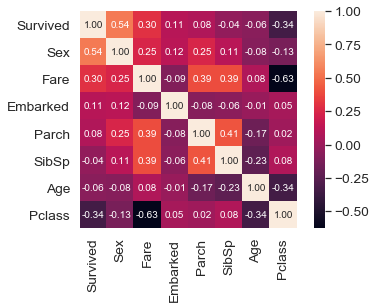

In [7]:
#Correlations
corrmat = train.corr()
k  = 8
cols = corrmat.nlargest(k, 'Survived')['Survived'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, \
                 square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [8]:
#Modeling 
X_train = train.drop(["Survived"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["SibSp"], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 6))

In [9]:
# For each X, calculate VIF and save in dataframe
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,3.8,Pclass
1,1.7,Sex
2,5.1,Age
3,1.8,SibSp
4,1.7,Parch
5,4.1,Fare
6,1.4,Embarked


Output for Feature selection using RFE:

In [10]:
#Feature selection using RFE
model = LogisticRegression()
rfe = RFE(model)
fit = rfe.fit(X_train, Y_train)
print("Num Features: ",fit.n_features_)
print("Selected Features: ",fit.support_)
print("Feature Ranking: ",fit.ranking_)
print(X_train.head())

Num Features:  3
Selected Features:  [ True  True False False False False  True]
Feature Ranking:  [1 1 5 2 4 3 1]
   Pclass  Sex   Age  SibSp  Parch  Fare  Embarked
0       3    0  22.0      1      0     0         0
1       1    1  38.0      1      0     3         1
2       3    1  26.0      0      0     1         0
3       1    1  35.0      1      0     3         0
4       3    0  35.0      0      0     1         0


Output for Feature selection using SelectKBest:

In [11]:
#Feature selection using SelectKBest
Kbestscore = SelectKBest(score_func=chi2, k=4)
fit = Kbestscore.fit(X_train, Y_train)
# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X_train)
# summarize selected features
print(features[0:5,:])
print (X_train.head())

[ 30.874 170.348  21.649   2.582  10.097  64.722  11.353]
[[ 3.  0. 22.  0.]
 [ 1.  1. 38.  3.]
 [ 3.  1. 26.  1.]
 [ 1.  1. 35.  3.]
 [ 3.  0. 35.  1.]]
   Pclass  Sex   Age  SibSp  Parch  Fare  Embarked
0       3    0  22.0      1      0     0         0
1       1    1  38.0      1      0     3         1
2       3    1  26.0      0      0     1         0
3       1    1  35.0      1      0     3         0
4       3    0  35.0      0      0     1         0


In [12]:
#Drop variables after feature selection:
X_train = train.drop(["Survived","SibSp","Parch","Embarked"], axis=1)
Y_train = train["Survived"]
X_test  = test.drop(["SibSp","Parch","Embarked"], axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 4), (891,), (418, 4))

### 3) Learn a decision tree model with the Titanic training data using Gini index, plot your decision tree;

Decision tree with depth=3 is presented as below:


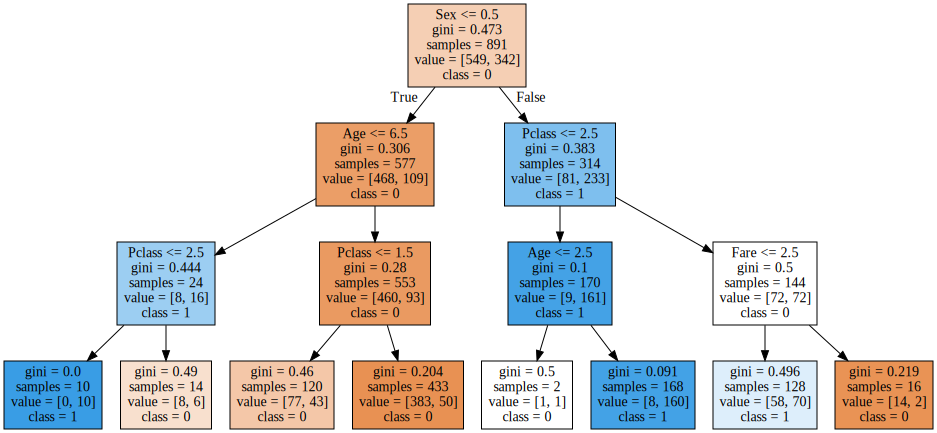

In [16]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                                feature_names=feature_cols,  
                                class_names=['0','1'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

### 4) Apply the five-fold cross validation of the decision tree learning algorithm to the Titanic training data to extract average classification accuracy;

In [20]:
#4)Model - Decision tree using GIni index - accuracy and AUC; 
# Create Decision Tree classifer object
decision_tree = DecisionTreeClassifier(max_depth=4)
# Train Decision Tree Classifer
clf = decision_tree.fit(X_train, Y_train)
acc = cross_val_score(clf, X_train, Y_train, cv=5)
scores = cross_val_score(clf, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Decision tree classification accuracy:", acc)
print("5K CV Decision tree average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Decision tree: ", scores.mean())

5K CV Decision tree classification accuracy: [0.765 0.809 0.798 0.775 0.843]
5K CV Decision tree average classification accuracy:  0.7980164459230431
=== Mean AUC Score ===
Training Mean AUC Score - Decision tree:  0.8351005597873191


### 5) Apply the five-fold cross validation of the random forest learning algorithm to the Titanic training data to extract average classification accuracy;

In [21]:
#5)Model - random forest- accuracy and AUC; 
random_forest = RandomForestClassifier(n_estimators=1400,random_state = 2020)
rff = random_forest.fit(X_train, Y_train)
acc = cross_val_score(rff, X_train, Y_train, cv=5)
scores = cross_val_score(rff, X_train, Y_train, cv=5, scoring='roc_auc')

print("5K CV Random Forest classification accuracy:", acc)
print("5K CV Random Forest average classification accuracy: ", acc.mean())
print("=== Mean AUC Score ===")
print("Training Mean AUC Score - Random Forest: ", scores.mean())

5K CV Random Forest classification accuracy: [0.754 0.792 0.837 0.815 0.826]
5K CV Random Forest average classification accuracy:  0.8047705730964786
=== Mean AUC Score ===
Training Mean AUC Score - Random Forest:  0.844975220896641


### 6) Which algorithm is better, Decision Tree or Random Forest?

Random Forest is better with higher average accuracy (0.805>0.798) and mean AUC of ROC (0.845>0.835). Also, after data partition into 80% vs 20% training and validation. F1-scores for training and validation were presented as below: Random forest has a higher F1 score for both training and validation. Overall random forest is better.

In [14]:
#after variable selection F1
X=train.drop(columns=['Survived','SibSp','Parch','Embarked']).values
Y=train['Survived'].values
XX_train, XX_test, YY_train, YY_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
# Building Decision Tree
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
dt.fit(XX_train, YY_train)
dt_pred_train = dt.predict(XX_train)

# Evaluation on Training set
dt_pred_train = dt.predict(XX_train)
print('DT Training Set Evaluation F1-Score=>',f1_score(YY_train,dt_pred_train))

# Evaluating on Test set
dt_pred_test = dt.predict(XX_test)
print('DT Validation Set Evaluation F1-Score=>',f1_score(YY_test,dt_pred_test))

# Building  Random Forest Classifier
rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(XX_train, YY_train)

# Evaluating on Training set
rfc_pred_train = rfc.predict(XX_train)
print('RF Training Set Evaluation F1-Score=>',f1_score(YY_train,rfc_pred_train))

# Evaluating on Test set
rfc_pred_test = rfc.predict(XX_test)
print('RF Validation Set Evaluation F1-Score=>',f1_score(YY_test,rfc_pred_test))

DT Training Set Evaluation F1-Score=> 0.8879999999999999
DT Validation Set Evaluation F1-Score=> 0.7248322147651007
RF Training Set Evaluation F1-Score=> 0.8910505836575876
RF Validation Set Evaluation F1-Score=> 0.7631578947368421


### 7) What can you learn from the algorithm comparison and analysis?

Random forest is a bagging method by combining week classifers into a stronger prediction model and also de-correlated variables, thus reduce variance and overffiting. It generally has better performance than decision tree.

## Task 2
### (a) 
Training error = Number of wrong predictions / Total number of predictions = (5+6+2+6+5+5)/(14+5+6+7+2+10+8+6+5+17+15+5) =0.29

### (b) 
T will be assign to +. 
The results will be decided by the probability of class = "+" compared with class = "-". There are three weighted probabilities (3 branches) need to be combined. 
1. A=0 -->B & B=1 -->E & E =0 -->  p(+)=2/12 =1/6 & p(-)=10/12=5/6 ; 
2. C=1 --> p(+)=15/20=3/4 & p(-)=5/20=1/4; 
3. D=1 --> p(+)=6/13 & p(-)=7/13;
three weights for 123 branches are (2+10)/(2+10+6+7+15+5);(15+5)/(2+10+6+7+15+5);(6+7)/(2+10+6+7+15+5)
so the sum of weighted probability of "+" is 0.51 over 0.5. so T will be assigned to +.

## Task 3
### Q1: What is the overall entropy before splitting?

Entropy(p)= -(4/10)log((4/10) - (6/10)log(6/10) = 0.971

### Q2: What is the gain in entropy after splitting on A?

T (7/10) entropy: -(4/7)log(4/7)-(3/7)log(3/7) = 0.985;

F (3/10) entropy: -0log0-(3/3)log(3/3) = 0

Gain on A: Entropy(p)- (T (7/10) entropy + F (3/10) entropy) = -(4/10)log((4/10) - (6/10)log(6/10) -[(7/10)*(-(4/7)log(4/7)-(3/7)log(3/7)) + (3/10)*0] = 0.281

### Q3: What is the gain in entropy after splitting on B:

T (4/10) entropy: -(3/4)log(3/4)-(1/4)log(1/4) = 0.811;

F (6/10) entropy: -(1/6)log(1/6)-(5/6)log(5/6) = 0.65

Gain on A: Entropy(p)- (T (4/10) entropy + F (6/10) entropy) = -(4/10)log((4/10) - (6/10)log(6/10) -[(4/10) *(-(3/4)log(3/4)-(1/4)log(1/4)) + (6/10)*(-(1/6)log(1/6)-(5/6)log(5/6))] = -0.065

### Q4: Which attribute would the decision tree choose?

Choose A which has higher information gain 0.281 > -0.065

### Q5: Draw the full decision tree that would be learned for this dataset. You do not need to show any calculations. (We want to split first on the variable which maximizes the information gain until there are no nodes with two class labels. )

Please see the attached picture with the submission or find it under my github folder.

## Task 4
### Q1: Are decision trees a linear classifier?

Decision trees are non-linear classifer.

### Q2: What are the weaknesses of decision trees?

They are unstable. A small change in the data can lead to a large change in the structure of the optimal decision tree.
Decision trees are biased for categorical variables with different number of levels. Information gain in decision trees is in favor of those attributes with more levels.

### Q3: Is Misclassification errors better than Gini index as the splitting criteria for decision trees?

No. Gini index is better than misclassificatin errors as the splitting criteria. Gini index is more sensitive to changes in the node probabilities than the misclassification errors.

In [ ]:
#Task2 (a)
(5+6+2+6+5+5)/(14+5+6+7+2+10+8+6+5+17+15+5) 

In [ ]:
#Task2 (b)
(1/6) * (2+10)/(2+10+6+7+15+5)  +3/4 * (15+5)/(2+10+6+7+15+5) +6/13 * (6+7)/(2+10+6+7+15+5)

In [ ]:
#Task3 Q1
import math
-(4/10)*math.log2(4/10) - (6/10)*math.log2(6/10)


In [ ]:
#Task3 Q2
-(4/7)*math.log2(4/7)-(3/7)*math.log2(3/7)


In [ ]:
#Task3 Q2
-(4/10)*math.log2(4/10) - (6/10)*math.log2(6/10) - (7/10)*(-(4/7)*math.log2(4/7)-(3/7)*math.log2(3/7))

In [ ]:
#Task3 Q3
-(3/4)*math.log2(3/4)-(1/4)*math.log2(1/4)

In [ ]:
#Task3 Q3
-(1/6)*math.log2(1/6)-(5/6)*math.log2(5/6) 

In [ ]:
#Task3 Q3
-(1/6)*math.log2(1/6)-(5/6)*math.log2(5/6)  - ((4/10) *(-(3/4)*math.log2(3/4)-(1/4)*math.log2(1/4)) + (6/10)*(-(1/6)*math.log2(1/6)-(5/6)*math.log2(5/6)))